In [1]:
# Pronostico time trend + fourier seasonal
#
# =============================================================================

#
# Carga de datos
#
import nbimporter  #  type: ignore
import functions  #  type: ignore


df_orig = functions.load_data()
df_orig.head()
  

,yt_true
date,
1946-01-01,890
1946-02-01,992
1946-03-01,979
1946-04-01,959
1946-05-01,1110


In [2]:
#
# Componentes de tendencia lineal
#
df_orig = functions.add_linear_trend_component(df_orig)
df_orig = functions.add_month_component(df_orig)
df_orig.head() 
  

,yt_true,trend,month
date,,,
1946-01-01,890,0,1
1946-02-01,992,1,2
1946-03-01,979,2,3
1946-04-01,959,3,4
1946-05-01,1110,4,5


In [3]:
#
# Fourier
#
df_orig = functions.add_sin_cos_components(df_orig)
df_orig.head(15)

,yt_true,trend,month,sin_12m,cos_12m,sin_6m,cos_6m,sin_4m,cos_4m,sin_3m,cos_3m
date,,,,,,,,,,,
1946-01-01,890,0,1,5.000000e-01,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17,8.660254e-01,-0.5
1946-02-01,992,1,2,8.660254e-01,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00,-8.660254e-01,-0.5
1946-03-01,979,2,3,1.000000e+00,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.0
1946-04-01,959,3,4,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00,8.660254e-01,-0.5
1946-05-01,1110,4,5,5.000000e-01,-8.660254e-01,-8.660254e-01,0.5,1.000000e+00,3.061617e-16,-8.660254e-01,-0.5
1946-06-01,1546,5,6,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0,3.673940e-16,-1.000000e+00,-4.898587e-16,1.0
1946-07-01,1539,6,7,-5.000000e-01,-8.660254e-01,8.660254e-01,0.5,-1.000000e+00,-4.286264e-16,8.660254e-01,-0.5
1946-08-01,3401,7,8,-8.660254e-01,-5.000000e-01,8.660254e-01,-0.5,-4.898587e-16,1.000000e+00,-8.660254e-01,-0.5
1946-09-01,2092,8,9,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0,1.000000e+00,5.510911e-16,-7.347881e-16,1.0


In [4]:
#
# Particionamiento de los datos
#
(
    X_complete,
    y_complete,
    X_train,
    y_train,
    X_test,
    y_test,
) = functions.train_test_split(
    df=df_orig,
    x_columns=[
        "trend",
        "sin_12m",
        "cos_12m",
        "sin_6m",
        "cos_6m",
        "sin_4m",
        "cos_4m",
        "sin_3m",
        "cos_3m",
    ],
    y_column="yt_true",
)

In [5]:
#
# Especificación del modelo
#
from sklearn.pipeline import Pipeline  #  type: ignore
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler  #  type: ignore
from sklearn.linear_model import LinearRegression  #  type: ignore
from sklearn.compose import ColumnTransformer  #  type: ignore

pipeline = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [
                    (
                        "trend",
                        Pipeline(
                            [
                                ("poly", PolynomialFeatures(degree=3)),
                                ("scaler", MinMaxScaler()),
                            ]
                        ),
                        ["trend"],
                    ),
                ],
                remainder="passthrough",
            ),
        ),
        ("regressor", LinearRegression()),
    ]
)



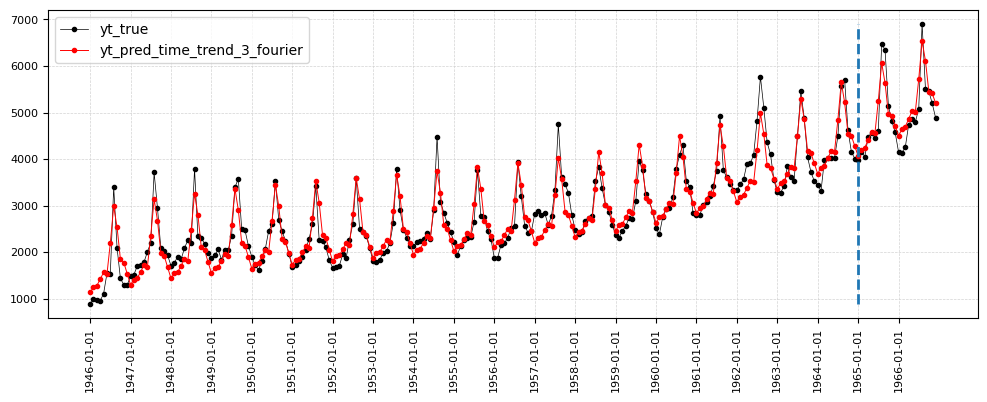

In [6]:
#
# Entrenamiento y pronostico
#
pipeline.fit(X_train, y_train)
df_orig["yt_pred_time_trend_3_fourier"] = pipeline.predict(X_complete)
functions.plot_time_series(df_orig)

In [7]:
#
# Almacenamiento de los resultados
#
functions.save_forecasts(df_orig)


In [8]:
#
# Métricas de error
#
metrics = functions.compute_evaluation_metrics(df_orig)
functions.save_metrics(metrics)
metrics

,Metrics,yt_pred_time_trend_3_fourier
0,MSE Train,76907.17
1,MSE Test,122981.45
2,MAE Train,214.10
3,MAE Test,278.01
